Lab 5 (Social Network Analysis) - Reddit - Part 2

This script extracts user and user interaction network from the top 20 hot posts in a subreddit (e.g., 'pics'). The user-user interaction pairs are saved as a CSV formatted network, where the source nodes are the users initiating comments and the target nodes are users replying to the comment, in the following format:

    source,target,weight

where the weight indicate the number of times the replying occurrs between the source and target nodes.

The output file is a CSV file, which can be opened in Gephi. It is an "directed" and "weighted" social network.

This script itself also contains visualization of the network independent of Gelphi.

In [1]:
%pip install python-louvain

Note: you may need to restart the kernel to use updated packages.


In [1]:
from dotenv import load_dotenv
load_dotenv()
import os

In [2]:
import praw
import networkx as nx
import matplotlib.pyplot as plt
import csv
from collections import defaultdict  # Import defaultdict

# Reddit API credentials
reddit = praw.Reddit(
    client_id = os.getenv("client_id"), # See slide 9 & 10 of Lab 2 Guide
    client_secret = os.getenv("client_secret"), # See slide 9 & 10 of Lab 2 Guide
    username = os.getenv("username"), # See slide 4 (step 3) of Lab 2 Guide
    password = os.getenv("password"),  # See slide 4 (step 3) of Lab 2 Guide
    user_agent = os.getenv("user_agent") # See slide 9 & 10 of Lab 2 Guide
)

Version 7.7.1 of praw is outdated. Version 7.8.1 was released 1 day ago.


In [3]:
# Function to recursively extract user interactions (replies) from a Reddit comment
def extract_user_interactions(comment, user_interactions):
    interactions = defaultdict(int)  # Use defaultdict to count interactions

    # Check if the comment has a valid author
    if hasattr(comment, 'author') and comment.author is not None:
        source_user = comment.author.name

        # Extract user interactions (replies) from the comment's replies
        for reply in comment.replies:
            if hasattr(reply, 'author') and reply.author is not None:
                target_user = reply.author.name
                interactions[(source_user, target_user)] += 1  # Count interactions

                # Recursively extract interactions from replies to replies
                extract_user_interactions(reply, user_interactions)

    # Convert interactions to a list of tuples (source_user, target_user, weight)
    for (source_user, target_user), weight in interactions.items():
        user_interactions.append((source_user, target_user, weight))
        print(source_user, "-->", target_user, weight)

In [4]:
# Specify the subreddit and post limit for data extraction
subreddit_name = "apexlegends"  # Replace with the subreddit of your choice
num_posts = 20  # Number of top posts to fetch

# Create a list to store user interactions as tuples (source_user, target_user)
user_interactions = []

# Fetch top posts from the specified subreddit
subreddit = reddit.subreddit(subreddit_name)
for submission in subreddit.top(limit=num_posts):
    # Extract user interactions (replies) from the post's comments
    if hasattr(submission, 'comments'):
        for comment in submission.comments:
            extract_user_interactions(comment, user_interactions)

# Save the user interactions to a CSV file
output_csv = "user_user_interaction_network.csv"
with open(output_csv, "w", newline="") as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(["source", "target", "weight"])
    csvwriter.writerows(user_interactions)
csvfile.close()

o_stats_o --> Darshly 1
Phanthiev --> o_stats_o 1
Sir_Boldrat --> Phanthiev 1
Sir_Boldrat --> KarpoPorus 1
Sir_Boldrat --> mimimar91 1
Valleyraven --> Affectionate_Bass488 1
LossforNos --> Valleyraven 1
LossforNos --> KFlex-Fantastic 1
Anghel412 --> Sir_Boldrat 1
Anghel412 --> LossforNos 1
Anghel412 --> asianfuf 1
Anghel412 --> Mongoose151 1
EnZooooTM --> theA1L12E5X24 1
rkrigney --> Solid_Freakin_Snake 1
rkrigney --> 11010110101010101010 1
rkrigney --> EnZooooTM 1
GARBANSO97 --> postplayshotsharp 1
make_love_to_potato --> ZzeroBeat 1
make_love_to_potato --> GARBANSO97 1
LeglessBILL --> make_love_to_potato 1
Colorado_Constructor --> tiny_smile_bot 1
Mahale --> Solid_Freakin_Snake 1
sellyourselfshort --> Mahale 1
opsidezi --> elpinko 1
elpinko --> rkrigney 1
elpinko --> LeglessBILL 1
elpinko --> TheFlashyG 1
elpinko --> idkanythingmyman 1
elpinko --> Colorado_Constructor 1
elpinko --> sellyourselfshort 1
elpinko --> Skojebus 1
elpinko --> opsidezi 1
Bossmoss599 --> elpinko 1
Square_Salt

KeyboardInterrupt: 

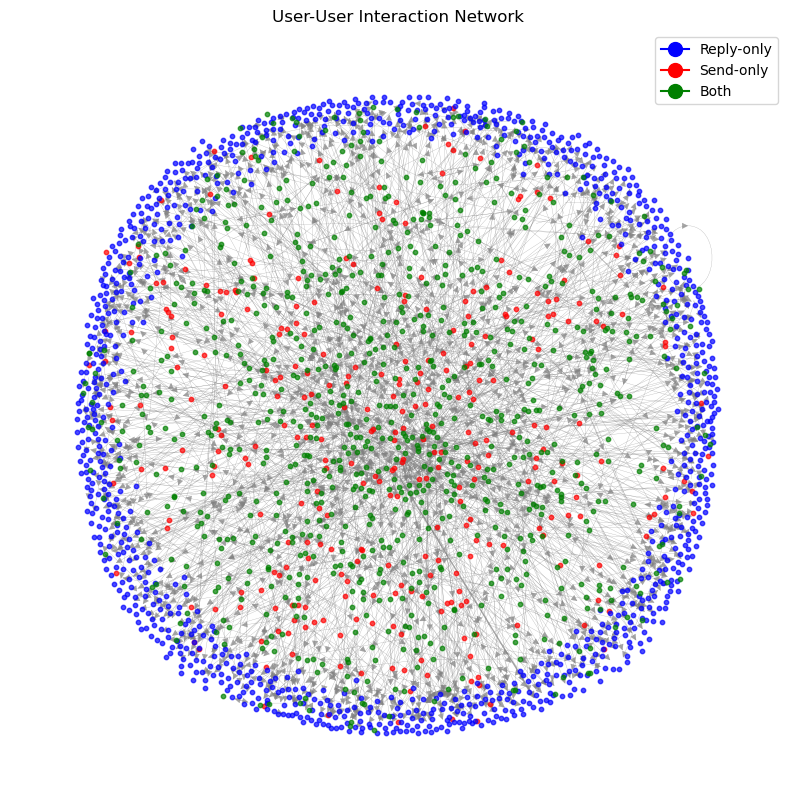

In [40]:
# Create a directed graph for the user interaction network
G = nx.DiGraph()
G.add_weighted_edges_from(user_interactions)

# Normalize edge weights for visualization
max_weight = max(weight for (source, target, weight) in user_interactions)
edge_weights = [(source, target, weight / max_weight) for (source, target, weight) in user_interactions]

# Plot the user interaction network with edge thickness indicating weight
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=0.1, iterations=50)  # Adjust layout parameters as needed
edge_labels = {(source, target): weight for (source, target, weight) in user_interactions}
edge_thickness = [weight/5 for (source, target, weight) in user_interactions]

# Draw nodes with different colors
source_users = {node: node for node in G.nodes() if G.out_degree(node) > 0 and G.in_degree(node) == 0}
target_users = {node: node for node in G.nodes() if G.out_degree(node) == 0 and G.in_degree(node) > 0}
other_users  = {node: node for node in G.nodes() if G.out_degree(node) > 0 and G.in_degree(node) > 0}
nx.draw_networkx_nodes(G, pos, nodelist=source_users, node_size=10, node_color='red', alpha=0.7)
nx.draw_networkx_nodes(G, pos, nodelist=target_users, node_size=10, node_color='blue', alpha=0.7)
nx.draw_networkx_nodes(G, pos, nodelist=other_users,  node_size=10, node_color='green', alpha=0.7)

# Draw edges with thickness indicating weight
nx.draw_networkx_edges(G, pos, width=edge_thickness, edge_color='gray', alpha=0.7)

# Create a custom legend for node colors
blue_node = plt.Line2D([0], [0], marker='o', color='blue', label='Reply-only', markersize=10)
red_node = plt.Line2D([0], [0], marker='o', color='red', label='Send-only', markersize=10)
green_node = plt.Line2D([0], [0], marker='o', color='green', label='Both', markersize=10)
plt.legend(handles=[blue_node, red_node, green_node], loc='upper right')

plt.title("User-User Interaction Network")
plt.axis('off')

# Save the plot as an image (e.g., PNG)
plt.savefig("user_user_interaction_network.png", format="PNG")
plt.show()

### Overwatch 2

In [41]:
# Function to recursively extract user interactions (replies) from a Reddit comment
def extract_user_interactions(comment, user_interactions):
    interactions = defaultdict(int)  # Use defaultdict to count interactions

    # Check if the comment has a valid author
    if hasattr(comment, 'author') and comment.author is not None:
        source_user = comment.author.name

        # Extract user interactions (replies) from the comment's replies
        for reply in comment.replies:
            if hasattr(reply, 'author') and reply.author is not None:
                target_user = reply.author.name
                interactions[(source_user, target_user)] += 1  # Count interactions

                # Recursively extract interactions from replies to replies
                extract_user_interactions(reply, user_interactions)

    # Convert interactions to a list of tuples (source_user, target_user, weight)
    for (source_user, target_user), weight in interactions.items():
        user_interactions.append((source_user, target_user, weight))
        print(source_user, "-->", target_user, weight)

In [42]:
# Specify the subreddit and post limit for data extraction
subreddit_name = "overwatch2"  # Replace with the subreddit of your choice
num_posts = 20  # Number of top posts to fetch

# Create a list to store user interactions as tuples (source_user, target_user)
user_interactions = []

# Fetch top posts from the specified subreddit
subreddit = reddit.subreddit(subreddit_name)
for submission in subreddit.top(limit=num_posts):
    # Extract user interactions (replies) from the post's comments
    if hasattr(submission, 'comments'):
        for comment in submission.comments:
            extract_user_interactions(comment, user_interactions)

# Save the user interactions to a CSV file
output_csv = "overwatch2_user_user_interaction_network.csv"
with open(output_csv, "w", newline="") as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(["source", "target", "weight"])
    csvwriter.writerows(user_interactions)
csvfile.close()

CinnamonIsntAllowed --> RoyalwithCheese10 1
CinnamonIsntAllowed --> lordbrooklyn56 1
Turbulent_Diver8330 --> blackgandalff 1
sean_starkey --> Joweany 1
sean_starkey --> Turbulent_Diver8330 1
WifeKnowsThisAcct --> sean_starkey 1
WifeKnowsThisAcct --> Jcorn3371 1
WifeKnowsThisAcct --> intotheirishole 1
WifeKnowsThisAcct --> SireSweet 1
WifeKnowsThisAcct --> N0tJime 1
WifeKnowsThisAcct --> Will_Smith_OFFICIAL 1
Phantom_Phoenix1 --> Ok_Philosopher_8956 1
throwawaySpikesHelp --> Ok_Philosopher_8956 1
throwawaySpikesHelp --> Mooniebutt 1
Ok_Philosopher_8956 --> Phantom_Phoenix1 1
Ok_Philosopher_8956 --> throwawaySpikesHelp 1
Coffee_Binzz --> Ok_Philosopher_8956 1
DidSome1SayExMachina --> ArticunoTrainer 1
C_Gull27 --> Standardly 1
Standardly --> C_Gull27 1
Chrysos-89 --> ssjgoten101 1
Chrysos-89 --> Rangastang 1
ReeceDnb --> toxicdudio 1
ReeceDnb --> sneakybandit991 1
ReeceDnb --> Standardly 1
ReeceDnb --> Chrysos-89 1
AndovarEdoras --> WifeKnowsThisAcct 1
AndovarEdoras --> phasttZ 1
Andovar

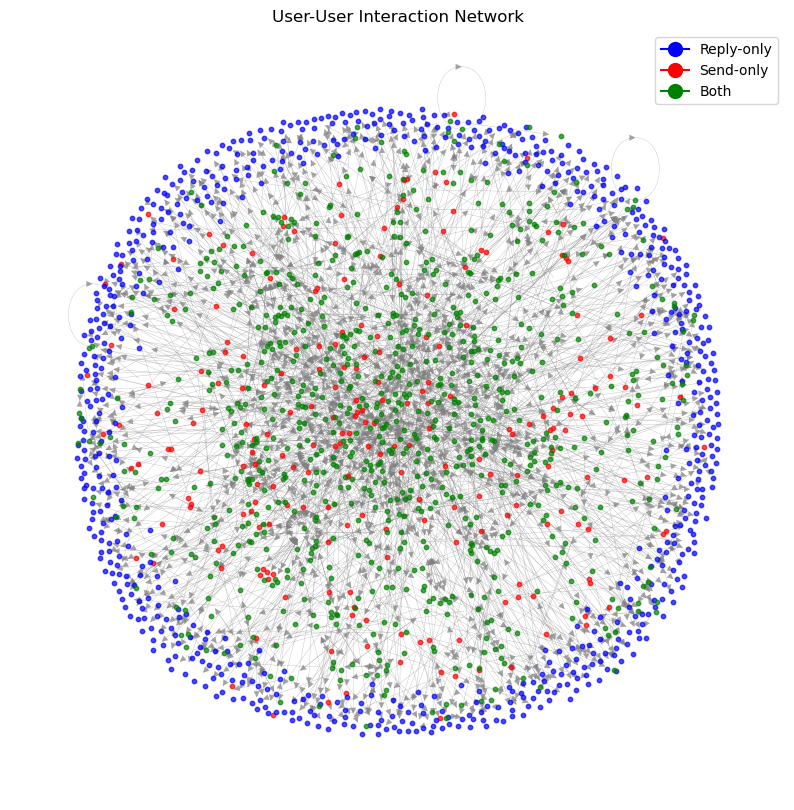

In [43]:
# Create a directed graph for the user interaction network
G2 = nx.DiGraph()
G2.add_weighted_edges_from(user_interactions)

# Normalize edge weights for visualization
max_weight = max(weight for (source, target, weight) in user_interactions)
edge_weights = [(source, target, weight / max_weight) for (source, target, weight) in user_interactions]

# Plot the user interaction network with edge thickness indicating weight
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G2, k=0.1, iterations=50)  # Adjust layout parameters as needed
edge_labels = {(source, target): weight for (source, target, weight) in user_interactions}
edge_thickness = [weight/5 for (source, target, weight) in user_interactions]

# Draw nodes with different colors
source_users = {node: node for node in G2.nodes() if G2.out_degree(node) > 0 and G2.in_degree(node) == 0}
target_users = {node: node for node in G2.nodes() if G2.out_degree(node) == 0 and G2.in_degree(node) > 0}
other_users  = {node: node for node in G2.nodes() if G2.out_degree(node) > 0 and G2.in_degree(node) > 0}
nx.draw_networkx_nodes(G2, pos, nodelist=source_users, node_size=10, node_color='red', alpha=0.7)
nx.draw_networkx_nodes(G2, pos, nodelist=target_users, node_size=10, node_color='blue', alpha=0.7)
nx.draw_networkx_nodes(G2, pos, nodelist=other_users,  node_size=10, node_color='green', alpha=0.7)

# Draw edges with thickness indicating weight
nx.draw_networkx_edges(G2, pos, width=edge_thickness, edge_color='gray', alpha=0.7)

# Create a custom legend for node colors
blue_node = plt.Line2D([0], [0], marker='o', color='blue', label='Reply-only', markersize=10)
red_node = plt.Line2D([0], [0], marker='o', color='red', label='Send-only', markersize=10)
green_node = plt.Line2D([0], [0], marker='o', color='green', label='Both', markersize=10)
plt.legend(handles=[blue_node, red_node, green_node], loc='upper right')

plt.title("User-User Interaction Network")
plt.axis('off')

# Save the plot as an image (e.g., PNG)
plt.savefig("overwatch2_user_user_interaction_network.png", format="PNG")
plt.show()

### Team Fortress 2

In [44]:
# Specify the subreddit and post limit for data extraction
subreddit_name = "teamfortress2"  # Replace with the subreddit of your choice
num_posts = 20  # Number of top posts to fetch

# Create a list to store user interactions as tuples (source_user, target_user)
user_interactions = []

# Fetch top posts from the specified subreddit
subreddit = reddit.subreddit(subreddit_name)
for submission in subreddit.top(limit=num_posts):
    # Extract user interactions (replies) from the post's comments
    if hasattr(submission, 'comments'):
        for comment in submission.comments:
            extract_user_interactions(comment, user_interactions)

# Save the user interactions to a CSV file
output_csv = "tf2_user_user_interaction_network.csv"
with open(output_csv, "w", newline="") as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(["source", "target", "weight"])
    csvwriter.writerows(user_interactions)
csvfile.close()

Egg3rYT --> Eponchik 1
dellconagher1 --> Glad_Flower_91 1
dellconagher1 --> InkDemonBATIM 1
InkDemonBATIM --> dellconagher1 1
dellconagher1 --> InkDemonBATIM 1
InkDemonBATIM --> dellconagher1 1
NOPE_guide --> Eponchik 1
Catsycatplays --> BasilyLeave 1
leandrohenri --> Eponchik 1
ItzBingus --> ExoTheFlyingFish 1
ExoTheFlyingFish --> MidHoovie 1
ExoTheFlyingFish --> ItzBingus 1
ItzBingus --> ExoTheFlyingFish 1
LIL_TUTTLE_b0ss --> Psychological-Bad512 1
executeBaja --> Iexistwithnoreason 1
Mojave_riot_328 --> Top_Debt2022 1
ComputerCultural9204 --> thatBlankt1 1
thatBlankt1 --> ComputerCultural9204 1
Thatone-Canadian --> Youraveragekidnapper 1
K3W4L --> Thatone-Canadian 1
PrintedScreen303 --> K3W4L 1
Budz_2_gaming_YT --> PrintedScreen303 1
KispyPenguin --> Budz_2_gaming_YT 1
Gaint_Mann --> Mandalorian____ 1
PhantomArcade_ --> Santas_cheese 1
PhantomArcade_ --> KispyPenguin 1
PhantomArcade_ --> WeiserPanzer 1
PhantomArcade_ --> Symbiosisthewolf 1
PhantomArcade_ --> Enimrac_G7 1
PhantomArca

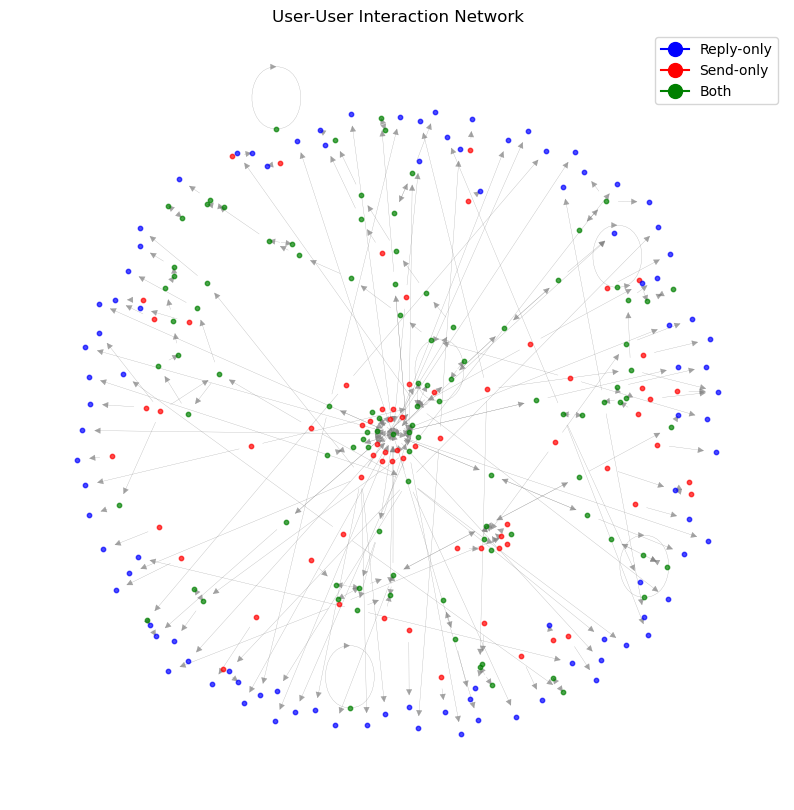

In [45]:
# Create a directed graph for the user interaction network
G3 = nx.DiGraph()
G3.add_weighted_edges_from(user_interactions)

# Normalize edge weights for visualization
max_weight = max(weight for (source, target, weight) in user_interactions)
edge_weights = [(source, target, weight / max_weight) for (source, target, weight) in user_interactions]

# Plot the user interaction network with edge thickness indicating weight
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G3, k=0.1, iterations=50)  # Adjust layout parameters as needed
edge_labels = {(source, target): weight for (source, target, weight) in user_interactions}
edge_thickness = [weight/5 for (source, target, weight) in user_interactions]

# Draw nodes with different colors
source_users = {node: node for node in G3.nodes() if G3.out_degree(node) > 0 and G3.in_degree(node) == 0}
target_users = {node: node for node in G3.nodes() if G3.out_degree(node) == 0 and G3.in_degree(node) > 0}
other_users  = {node: node for node in G3.nodes() if G3.out_degree(node) > 0 and G3.in_degree(node) > 0}
nx.draw_networkx_nodes(G3, pos, nodelist=source_users, node_size=10, node_color='red', alpha=0.7)
nx.draw_networkx_nodes(G3, pos, nodelist=target_users, node_size=10, node_color='blue', alpha=0.7)
nx.draw_networkx_nodes(G3, pos, nodelist=other_users,  node_size=10, node_color='green', alpha=0.7)

# Draw edges with thickness indicating weight
nx.draw_networkx_edges(G3, pos, width=edge_thickness, edge_color='gray', alpha=0.7)

# Create a custom legend for node colors
blue_node = plt.Line2D([0], [0], marker='o', color='blue', label='Reply-only', markersize=10)
red_node = plt.Line2D([0], [0], marker='o', color='red', label='Send-only', markersize=10)
green_node = plt.Line2D([0], [0], marker='o', color='green', label='Both', markersize=10)
plt.legend(handles=[blue_node, red_node, green_node], loc='upper right')

plt.title("User-User Interaction Network")
plt.axis('off')

# Save the plot as an image (e.g., PNG)
plt.savefig("tf2_user_user_interaction_network.png", format="PNG")
plt.show()

### Combined

In [46]:
combined_g = nx.compose_all([G,G2,G3])

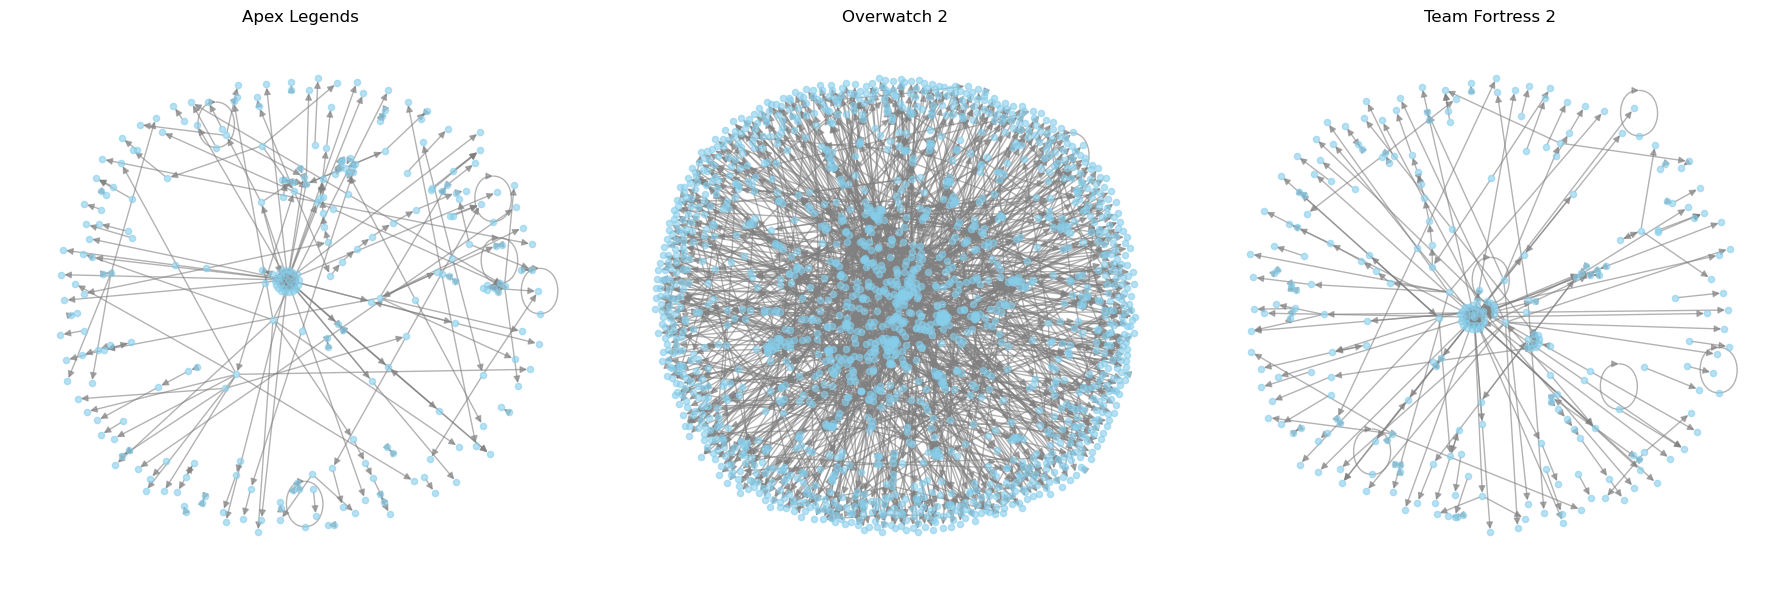

In [48]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_side_by_side_networks(G1, G2, G3):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    games = [G1, G2, G3]
    titles = ['Apex Legends', 'Overwatch 2', 'Team Fortress 2']
    
    for graph, ax, title in zip(games, (ax1, ax2, ax3), titles):
        pos = nx.spring_layout(graph)
        nx.draw(graph, pos, ax=ax, node_size=20, node_color='skyblue', edge_color='gray', alpha=0.6)
        ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_side_by_side_networks(G, G2, G3)

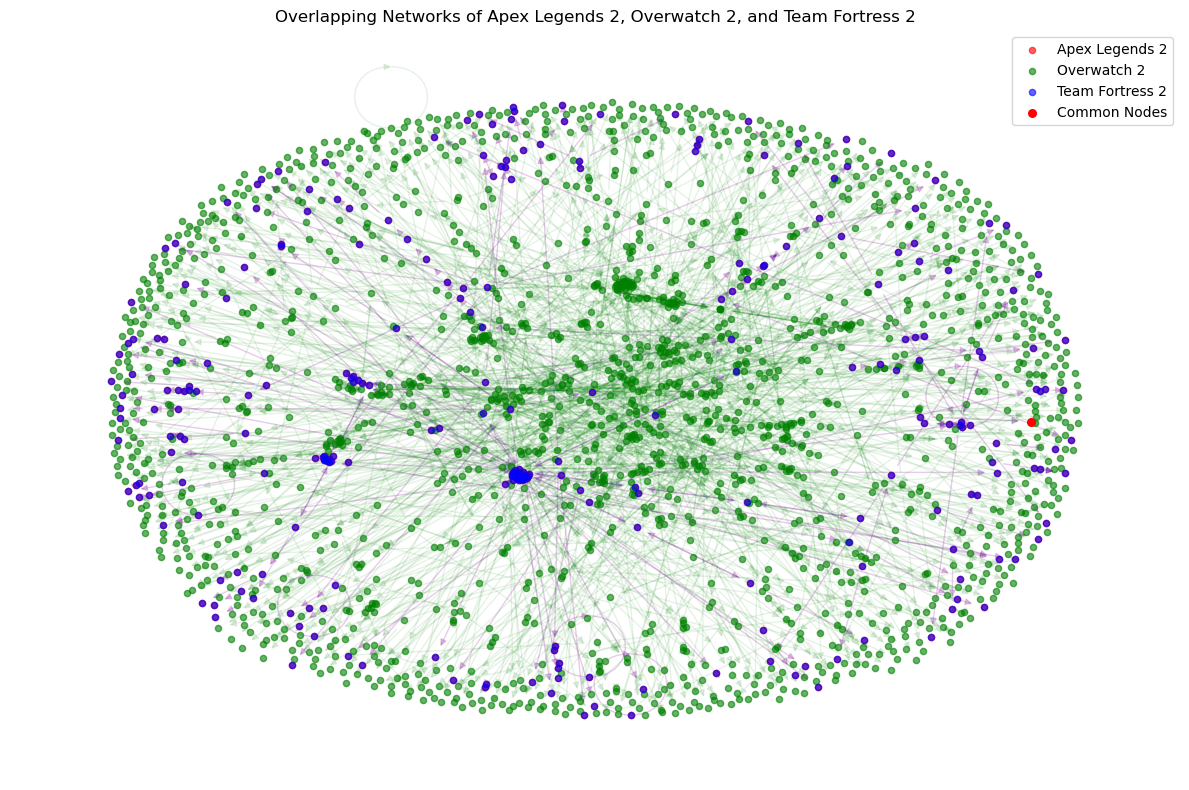

In [52]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_overlapping_networks(G1, G2, G3):
    plt.figure(figsize=(12, 8))
    
    pos = nx.spring_layout(nx.compose_all([G1, G2, G3]))
    
    nx.draw_networkx_nodes(G1, pos, node_color='red', node_size=20, alpha=0.6, label='Apex Legends 2')
    nx.draw_networkx_nodes(G2, pos, node_color='green', node_size=20, alpha=0.6, label='Overwatch 2')
    nx.draw_networkx_nodes(G3, pos, node_color='blue', node_size=20, alpha=0.6, label='Team Fortress 2')
    
    nx.draw_networkx_edges(G1, pos, edge_color='red', alpha=0.1)
    nx.draw_networkx_edges(G2, pos, edge_color='green', alpha=0.1)
    nx.draw_networkx_edges(G3, pos, edge_color='blue', alpha=0.1)
    
    common_nodes = set(G1.nodes()) & set(G2.nodes()) & set(G3.nodes())
    nx.draw_networkx_nodes(G1, pos, nodelist=common_nodes, node_color='red', node_size=30, label='Common Nodes')
    
    plt.legend()
    plt.title('Overlapping Networks of Apex Legends 2, Overwatch 2, and Team Fortress 2')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_overlapping_networks(G, G2, G3)

## Community Structure Comparison

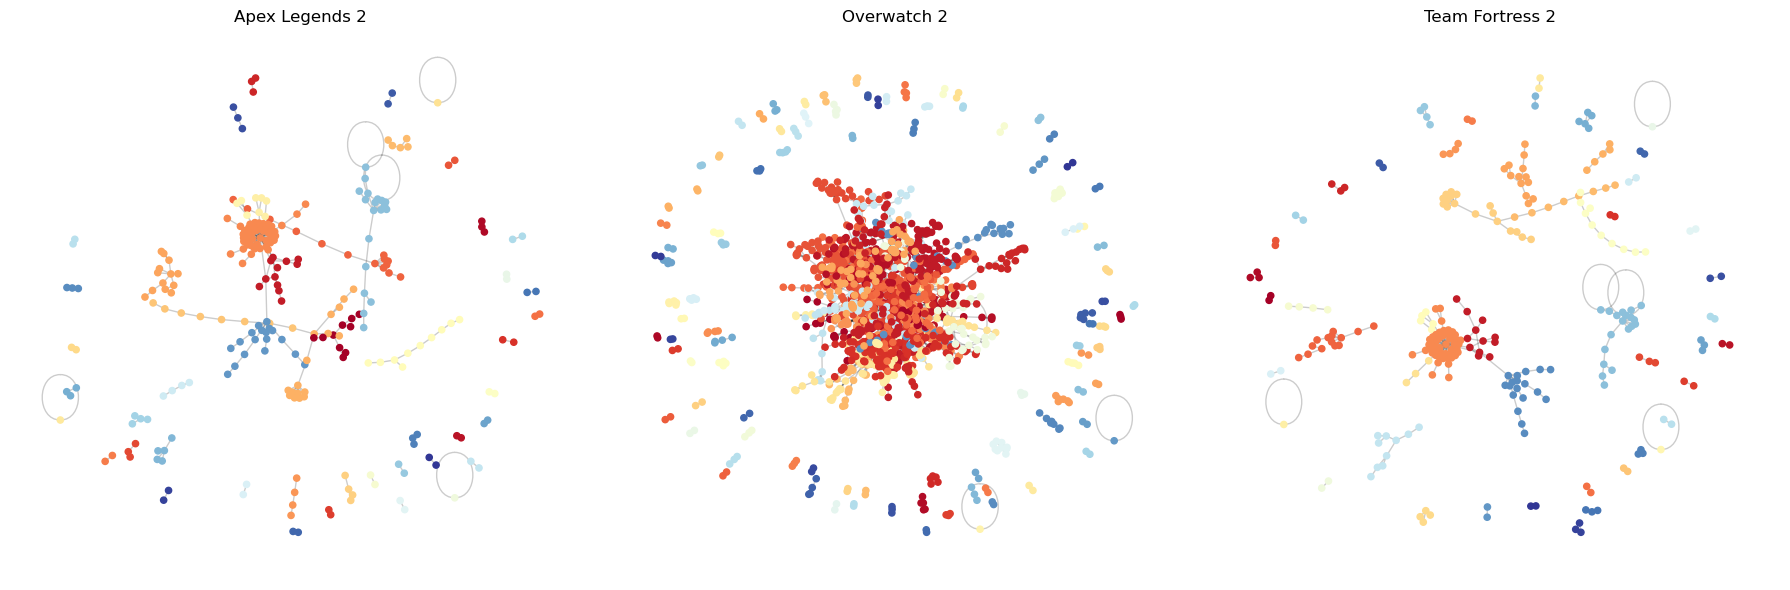

In [67]:
## LOUVAIN ALGO
from community import community_louvain
import networkx as nx
import matplotlib.pyplot as plt

def plot_community_structures(G1, G2, G3):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    games = [G1, G2, G3]
    titles = ['Apex Legends 2', 'Overwatch 2', 'Team Fortress 2']
    
    for G, ax, title in zip(games, (ax1, ax2, ax3), titles):
        partition = community_louvain.best_partition(G)
        pos = nx.spring_layout(G)
        
        nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=20, 
                               cmap=plt.cm.RdYlBu, node_color=list(partition.values()), ax=ax)
        nx.draw_networkx_edges(G, pos, alpha=0.2, ax=ax)
        
        ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_community_structures(G.to_undirected(), G2.to_undirected(), G.to_undirected())

## Ego Network

Game Community Characteristics: <br>
- Apex Legends 2 and Team Fortress 2 likely have dominant influencers who drive most of the communication or content creation in their communities, given their centrality and sparse connections between alters.
Overwatch 2, with its more clustered structure, may have smaller but more tightly-knit groups that communicate more among themselves rather than relying on one major influencer.


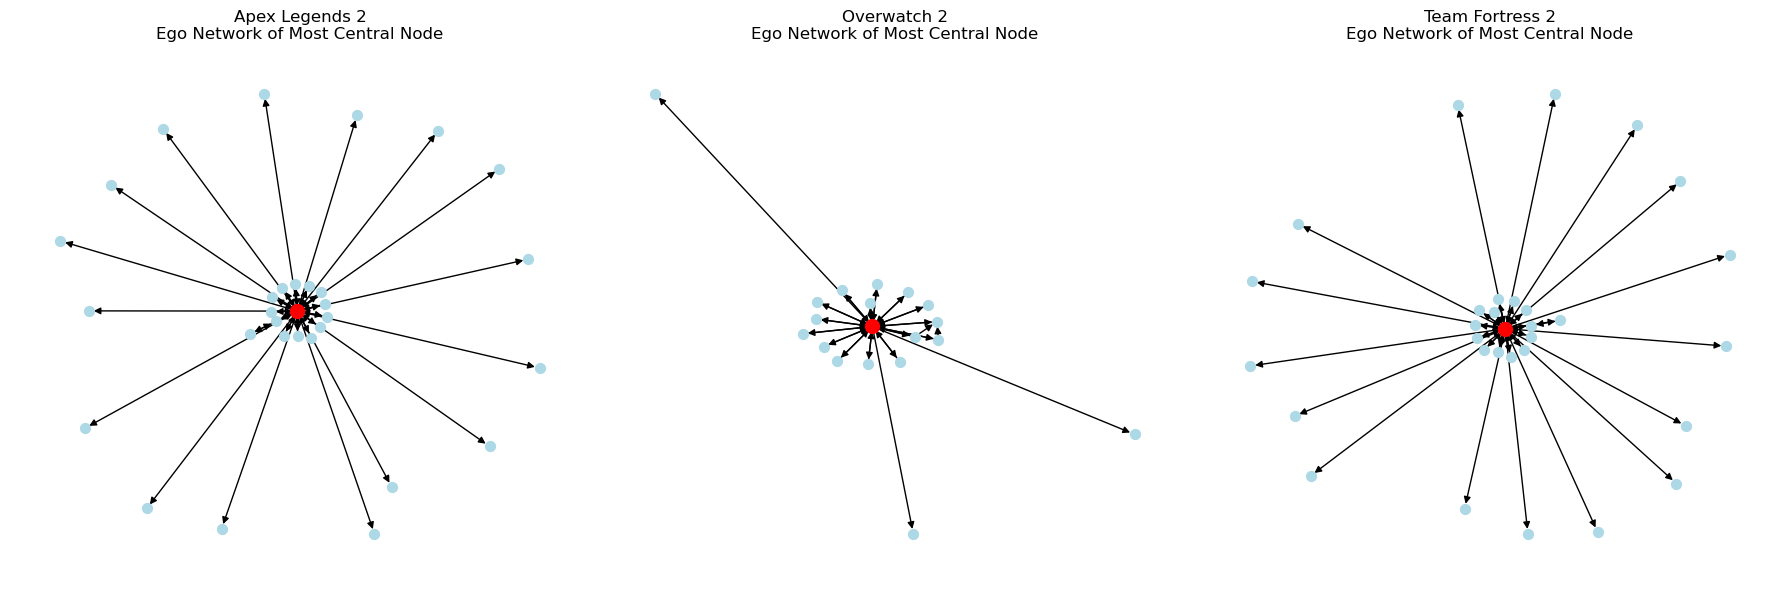

In [50]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_ego_network_comparison(G1, G2, G3):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    games = [G1, G2, G3]
    titles = ['Apex Legends 2', 'Overwatch 2', 'Team Fortress 2']
    
    for G, ax, title in zip(games, (ax1, ax2, ax3), titles):
        # Find the node with highest degree centrality
        central_node = max(nx.degree_centrality(G), key=nx.degree_centrality(G).get)
        
        # Create ego network
        ego_network = nx.ego_graph(G, central_node)
        
        # Draw the ego network
        pos = nx.spring_layout(ego_network)
        nx.draw(ego_network, pos, ax=ax, node_color='lightblue', node_size=50, with_labels=False)
        nx.draw_networkx_nodes(ego_network, pos, nodelist=[central_node], node_color='red', node_size=100, ax=ax)
        
        ax.set_title(f"{title}\nEgo Network of Most Central Node")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_ego_network_comparison(G, G2, G3)

## Intergame Nodes
- Nodes (usually representing users) that appear in the networks of two or more games.

{'Meta_Squid7121', 'solairs_the_dummy', 'Visible_Project_9568', 'Admirable_Plantain91', 'Capable_Kale_3793', 'Bryen5610', 'Epic_Hoola', 'pencilinatophat', 'FLAL201', 'Atlasamsung', 'MafiaPikaPika', 'AshuraReacts1992', 'Cywberth', 'Jayman1556', 'FUTURE10S', 'Speartonarethebest', 'AnAnnoyingAnimal', 'SansDaMan728', 'infernothehedgehog20', 'Funtime_Freddy54321', 'PopitaOooh', 'Elibriel', 'lucas_newton', 'nicejs2', 'Mastakillerboi', 'SodaPoPPeR012', 'coyotewitharedbull', 'Fantastic_Frosting98', 'Vaksik', 'WEIVELMAN37', 'Sufficient_Ad_1143', 'Symbiosisthewolf', 'GordonFreemanGaming', 'Omegalock2', 'Every_Ear1912', 'anti_thot_man', 'zambiechips433', 'DukeofPavia2009', 'YourMotherIsRiding', 'Holdup172', 'Huskydog_101', 'Cintrao', 'Acrobatic_Cat_6368', 'pootisman_doom69420', 'Imstillarelavant', 'Solid_Inspector649', 'ETANISC00L', 'bamber_reddit122', 'Speed9052', 'ImInfix', 'TheOneWhoLovesSW', 'PepperbroniFrom2B', 'Tunneltav', 'Youraveragekidnapper', 'Wrong-Caterpillar-94', 'RPG247A', 'Sani_G4y

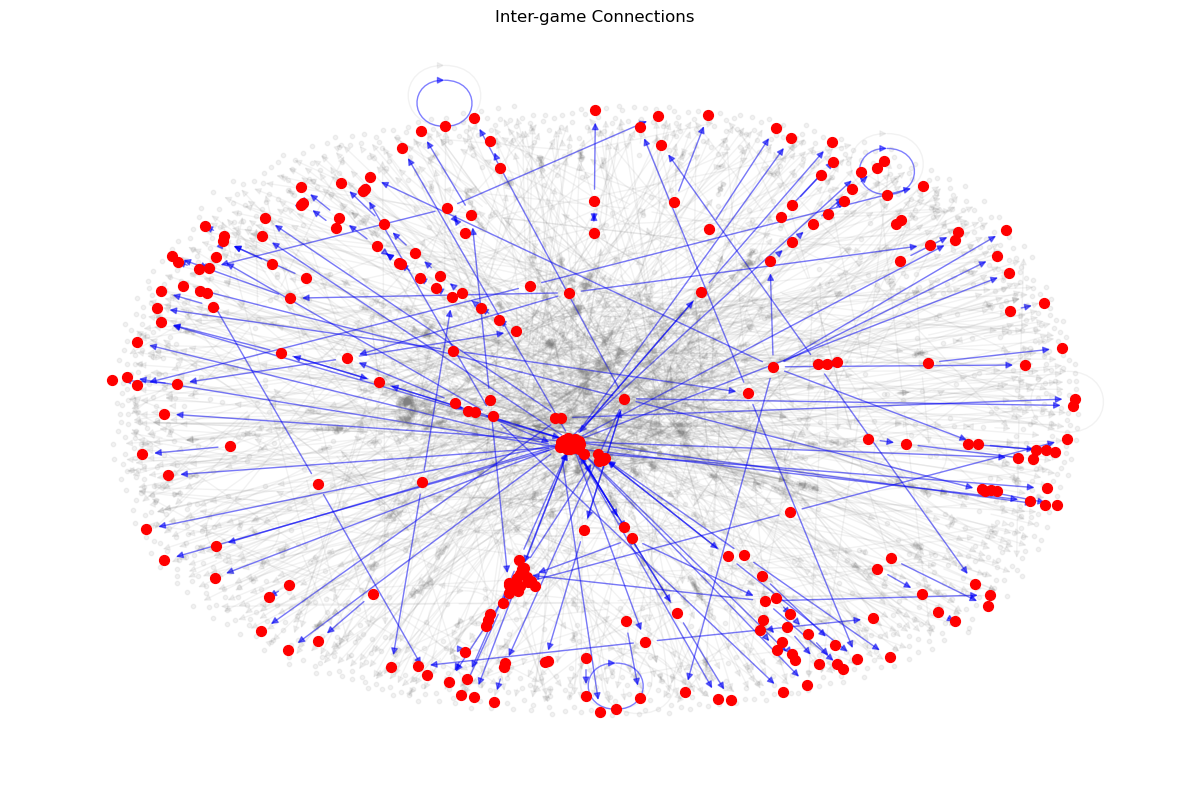

In [54]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_inter_game_connections(G1, G2, G3):
    plt.figure(figsize=(12, 8))
    
    # Combine all graphs
    G_combined = nx.compose_all([G1, G2, G3])
    
    # Identify nodes present in multiple games
    nodes_G1 = set(G1.nodes())
    nodes_G2 = set(G2.nodes())
    nodes_G3 = set(G3.nodes())
    
    inter_game_nodes = (nodes_G1 & nodes_G2) | (nodes_G2 & nodes_G3) | (nodes_G1 & nodes_G3)
    print(inter_game_nodes)
    
    # Create layout
    pos = nx.spring_layout(G_combined)
    
    # Draw all nodes and edges with low alpha
    nx.draw_networkx_nodes(G_combined, pos, node_color='gray', node_size=10, alpha=0.1)
    nx.draw_networkx_edges(G_combined, pos, edge_color='gray', alpha=0.1)
    
    # Highlight inter-game nodes and their connections
    nx.draw_networkx_nodes(G_combined, pos, nodelist=inter_game_nodes, node_color='red', node_size=50, alpha=1)
    
    for node in inter_game_nodes:
        neighbors = list(G_combined.neighbors(node))
        nx.draw_networkx_edges(G_combined, pos, edgelist=[(node, neighbor) for neighbor in neighbors], 
                               edge_color='blue', alpha=0.5)
    
    plt.title('Inter-game Connections')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_inter_game_connections(G, G2, G3)

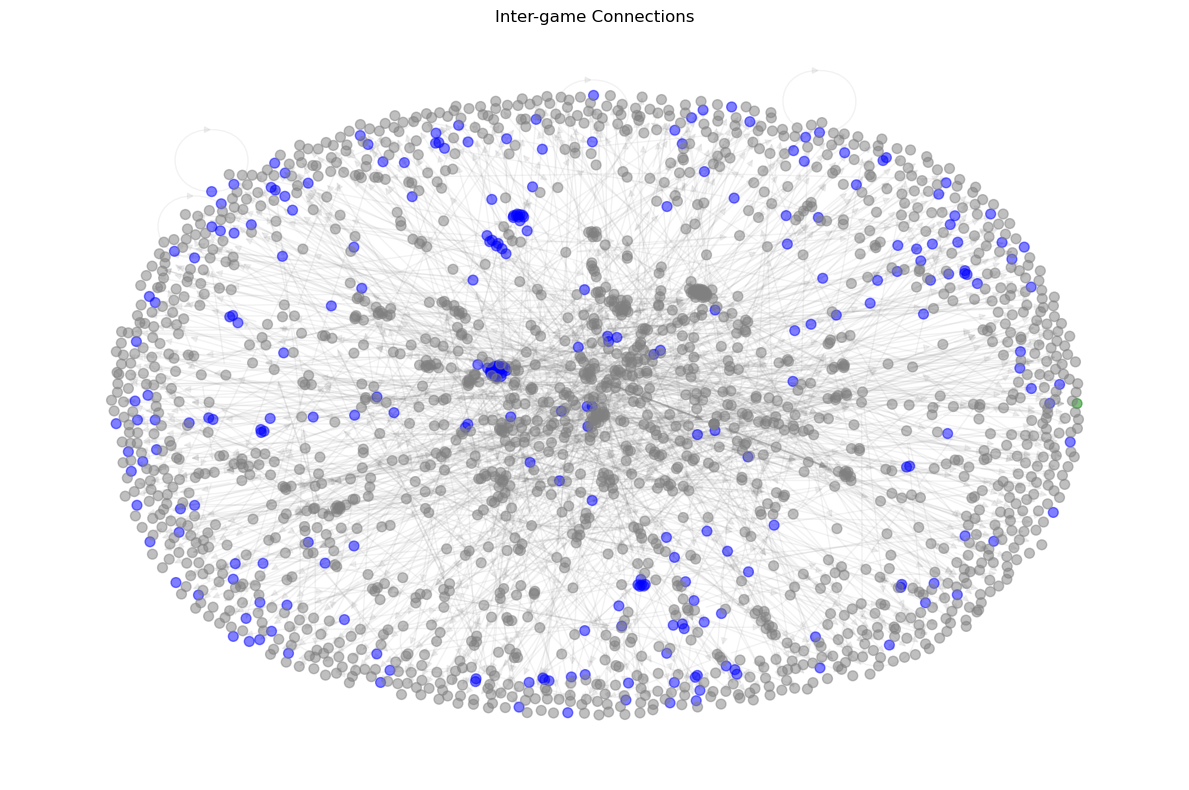

In [63]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_inter_game_connections(G1, G2, G3):
    plt.figure(figsize=(12, 8))
    
    # Combine all graphs
    G_combined = nx.compose_all([G1, G2, G3])
    
    # Identify nodes present in multiple games
    nodes_G1 = set(G1.nodes())
    nodes_G2 = set(G2.nodes())
    nodes_G3 = set(G3.nodes())
    
    inter_game_nodes = (nodes_G1 & nodes_G2) | (nodes_G2 & nodes_G3) | (nodes_G1 & nodes_G3)
    
    # Count the number of games each node appears in
    node_counts = {}
    for node in G_combined.nodes():
        count = 0
        if node in nodes_G1:
            count += 1
        if node in nodes_G2:
            count += 1
        if node in nodes_G3:
            count += 1
        node_counts[node] = count
    
    # Create node colors based on the count
    node_colors = []
    for node in G_combined.nodes():
        if node_counts[node] == 2:
            node_colors.append('blue')
        elif node_counts[node] == 3:
            node_colors.append('green')
        else:
            node_colors.append('grey')
    
    # Create layout
    pos = nx.spring_layout(G_combined)
    
    # Draw all nodes and edges with low alpha
    nx.draw_networkx_nodes(G_combined, pos, node_color=node_colors, node_size=50, alpha=0.5)
    nx.draw_networkx_edges(G_combined, pos, edge_color='gray', alpha=0.1)
    
    plt.title('Inter-game Connections')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_inter_game_connections(G, G2, G3)
